In [2]:
import os, re, json, gc, time

import torch
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer

import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
wnl = WordNetLemmatizer()


from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from huggingface_hub import login, logout

import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import numpy as np

from matplotlib import pyplot as plt

### Logging in to HuggingFace, downloading the model and reading the dataset

In [3]:
f = open("../hf_token_read", "r")
hf_token = f.read()
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/alkakumari/.cache/huggingface/token
Login successful


In [4]:
# Download the model and tokenizer
model_path = 'Alibaba-NLP/gte-large-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_path) #BertTokenizerFast
model = AutoModel.from_pretrained(model_path, trust_remote_code=True) 

In [5]:
pd.options.display.max_colwidth = 300
df_hatespeech = pd.read_csv('../data/english_dataset/english_dataset.tsv', sep='\t')

In [6]:
df_hatespeech.drop(['text_id','task_1','task_3'], axis=1, inplace=True)
df_hatespeech.rename(columns={'task_2':'class'}, inplace=True)
df_hatespeech['class'].value_counts()

class
NONE    3591
HATE    1143
PRFN     667
OFFN     451
Name: count, dtype: int64

In [7]:
df_hatespeech['class'] = df_hatespeech['class'].apply(lambda x: 0 if x == 'HATE'
                   else 1 if (x == 'PRFN' or x == 'OFFN')
                   else 2)  

In [8]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower()) #lowercase
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['text'] = df['text'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', 'MENTION', x)) #replace all @mentions to 'MENTION'
    df['text'] = df['text'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    df['text'] = df['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    return df

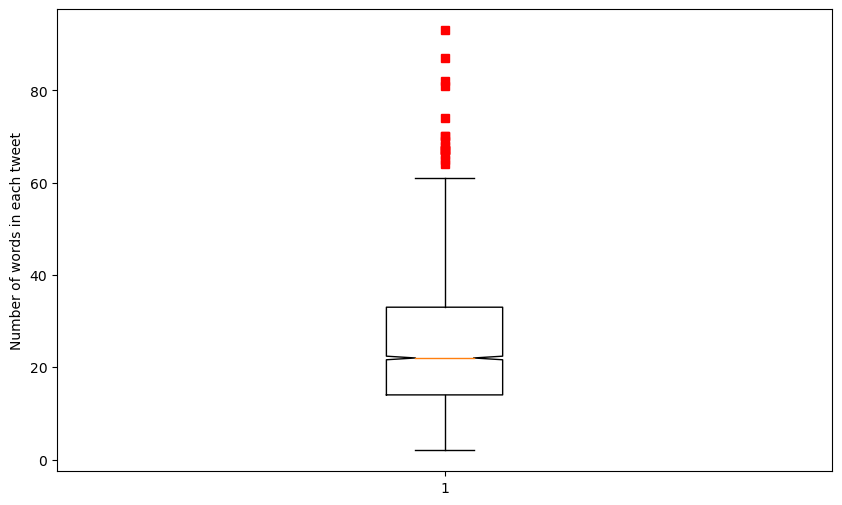

In [9]:
#Plotting boxplot to understand MAX_SEQ_LEN
frequency = []
for i in range(df_hatespeech.shape[0]):
    frequency.append(len(df_hatespeech['text'].iloc[i].split()))
plt.figure(figsize=(10, 6))
plt.boxplot(frequency, 
            notch = True,
            sym = 'rs')
plt.ylabel('Number of words in each tweet')
plt.show()

In [10]:
MAX_SEQ_LEN = 40

In [11]:
X = df_hatespeech.drop(columns=['class'])
Y = df_hatespeech['class']
X = clean(X)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)

In [12]:
del df_hatespeech
del f
del hf_token
del stopwords
del wnl
del X
del Y
gc.collect()

3081

In [13]:
token_temp = tokenizer(X_train["text"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )

In [14]:
embedding_batch_size = 190
num_batches = len(X_train) // embedding_batch_size + 1
print("Number of batches for training:", num_batches)

Number of batches for training: 25


In [15]:
for i in range(num_batches): 
    if i == 0:
        X_train_batch = X_train[:embedding_batch_size]
        print("Processing batch from 0 to", embedding_batch_size)
    elif i == num_batches - 1:
        X_train_batch = X_train[embedding_batch_size*i:]
        print("Processing batch from", embedding_batch_size*i, "to", len(X_train))
    else:
        X_train_batch = X_train[embedding_batch_size*i:embedding_batch_size*(i+1)]
        print("Processing batch from", embedding_batch_size*i, "to", embedding_batch_size*(i+1))
    token_temp = tokenizer(X_train_batch["text"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )
    outputs = model(**token_temp)
    X_train_embeddings = outputs.last_hidden_state[:, 0]
    tf_X_train_embeddings = tf.convert_to_tensor(X_train_embeddings.detach().numpy())
    if i == 0:
        tf_X_train_embeddings_concatnated = tf_X_train_embeddings
    else:
        tf_X_train_embeddings_concatnated = tf.concat([tf_X_train_embeddings_concatnated, tf_X_train_embeddings], axis=0)
    del X_train_batch
    del token_temp
    del outputs
    del X_train_embeddings
    del tf_X_train_embeddings
    gc.collect()
    time.sleep(0.5)

Processing batch from 0 to 190
Processing batch from 190 to 380
Processing batch from 380 to 570
Processing batch from 570 to 760
Processing batch from 760 to 950
Processing batch from 950 to 1140
Processing batch from 1140 to 1330
Processing batch from 1330 to 1520
Processing batch from 1520 to 1710
Processing batch from 1710 to 1900
Processing batch from 1900 to 2090
Processing batch from 2090 to 2280
Processing batch from 2280 to 2470
Processing batch from 2470 to 2660
Processing batch from 2660 to 2850
Processing batch from 2850 to 3040
Processing batch from 3040 to 3230
Processing batch from 3230 to 3420
Processing batch from 3420 to 3610
Processing batch from 3610 to 3800
Processing batch from 3800 to 3990
Processing batch from 3990 to 4180
Processing batch from 4180 to 4370
Processing batch from 4370 to 4560
Processing batch from 4560 to 4681


In [16]:
num_batches = len(X_val) // embedding_batch_size + 1
num_batches

7

In [17]:
for i in range(num_batches): 
    if i == 0:
        X_val_batch = X_val[:embedding_batch_size]
        print("Processing batch from 0 to", embedding_batch_size)
    elif i == num_batches - 1:
        X_val_batch = X_val[embedding_batch_size*i:]
        print("Processing batch from", embedding_batch_size*i, "to", len(X_val))
    else:
        X_val_batch = X_val[embedding_batch_size*i:embedding_batch_size*(i+1)]
        print("Processing batch from", embedding_batch_size*i, "to", embedding_batch_size*(i+1))
    token_temp = tokenizer(X_val_batch["text"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )
    outputs = model(**token_temp)
    X_val_embeddings = outputs.last_hidden_state[:, 0]
    tf_X_val_embeddings = tf.convert_to_tensor(X_val_embeddings.detach().numpy())
    if i == 0:
        tf_X_val_embeddings_concatnated = tf_X_val_embeddings
    else:
        tf_X_val_embeddings_concatnated = tf.concat([tf_X_val_embeddings_concatnated, tf_X_val_embeddings], axis=0)
    del X_val_batch
    del token_temp
    del outputs
    del X_val_embeddings
    del tf_X_val_embeddings
    gc.collect()
    time.sleep(2)

Processing batch from 0 to 190
Processing batch from 190 to 380
Processing batch from 380 to 570
Processing batch from 570 to 760
Processing batch from 760 to 950
Processing batch from 950 to 1140
Processing batch from 1140 to 1171


In [18]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
#If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)

In [19]:
learning_rate = 0.00003

In [20]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = LSTM(500, return_sequences=True)(text_input)
    x = dropout(0.8)(x)
    x = LSTM(300)(x)
    x = dropout(0.7)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = simpleRNN(500)(text_input)
    x = dropout(0.8)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = GRU(500)(text_input)
    x = dropout(0.8)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
def novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003):
    Bidirectional = tf.keras.layers.Bidirectional
    model = tf.keras.Sequential()
    model.add(Bidirectional(GRU(40, activation='relu', return_sequences=True, name='BiDirectionalGRUlayer'))) #GRU layer with 40 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Bidirectional(LSTM(20, recurrent_activation='relu', return_sequences=True))) #LSTM layer with 20 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Dense(15)) #Dense layer with 16 units and relu activation function
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(simpleRNN(10)) #SimpleRNN layer with 10 units
    model.add(Dense(10)) #Dense layer with 16 units and relu activation function
    model.add(Dense(3, activation='softmax')) #Output layer with 3 units and softmax activation function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True, ema_momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['accuracy'])
    return model

In [24]:

def train(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=6,
                                                      mode='min',
                                                      restore_best_weights=True)
      X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
      print(X_train.shape)
      X_val = tf.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
      history = model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val), 
            epochs=epochs, 
            batch_size=batch_size, 
            #class_weight=class_weights,
            callbacks=callback,
            shuffle=True,
            verbose=2)
      print("\n\n****************************\n\n")
      print("Model trained successfully")
      pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
      
      y_true = np.argmax(Y_val, axis=1)
      y_pred = np.argmax(pred, axis=1)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      # Calculate AUC and plot ROC curve
      auc = roc_auc_score(Y_val, pred, multi_class='ovr', average='weighted')
      fpr, tpr, _ = roc_curve(Y_val.ravel(), pred.ravel())
    
      print("AUC: ", auc)
      print("Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)
      print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
      
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      
      return history

In [25]:
def evaluate_model(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_accuracy)), train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(val_accuracy)), val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_loss)), train_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(val_loss)), val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

(4681, 1, 1024)
Epoch 1/100
37/37 - 2s - loss: 0.9826 - accuracy: 0.5734 - val_loss: 0.9185 - val_accuracy: 0.6072 - 2s/epoch - 65ms/step
Epoch 2/100
37/37 - 1s - loss: 0.8959 - accuracy: 0.6161 - val_loss: 0.8848 - val_accuracy: 0.6106 - 714ms/epoch - 19ms/step
Epoch 3/100
37/37 - 1s - loss: 0.8609 - accuracy: 0.6298 - val_loss: 0.8660 - val_accuracy: 0.6200 - 762ms/epoch - 21ms/step
Epoch 4/100
37/37 - 1s - loss: 0.8420 - accuracy: 0.6364 - val_loss: 0.8574 - val_accuracy: 0.6260 - 832ms/epoch - 22ms/step
Epoch 5/100
37/37 - 1s - loss: 0.8268 - accuracy: 0.6458 - val_loss: 0.8498 - val_accuracy: 0.6251 - 734ms/epoch - 20ms/step
Epoch 6/100
37/37 - 1s - loss: 0.8122 - accuracy: 0.6479 - val_loss: 0.8448 - val_accuracy: 0.6217 - 808ms/epoch - 22ms/step
Epoch 7/100
37/37 - 1s - loss: 0.8112 - accuracy: 0.6477 - val_loss: 0.8431 - val_accuracy: 0.6277 - 730ms/epoch - 20ms/step
Epoch 8/100
37/37 - 1s - loss: 0.8000 - accuracy: 0.6546 - val_loss: 0.8437 - val_accuracy: 0.6311 - 695ms/epoch

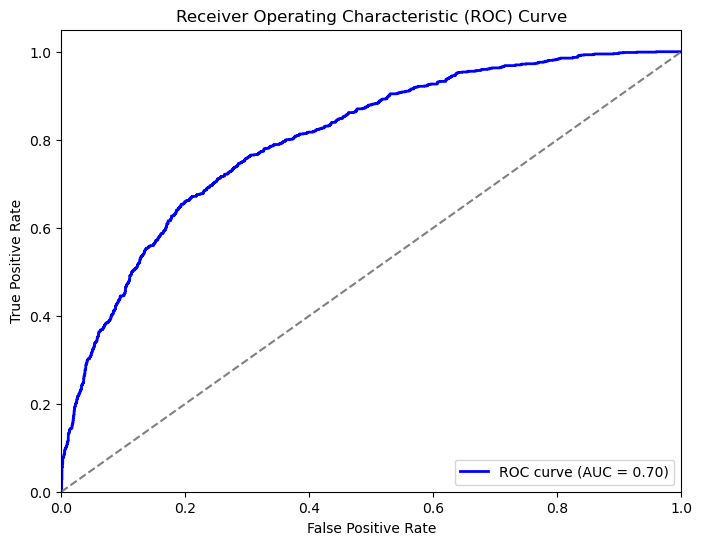

In [26]:
m = model_LSTM(1024)
history_LSTM = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

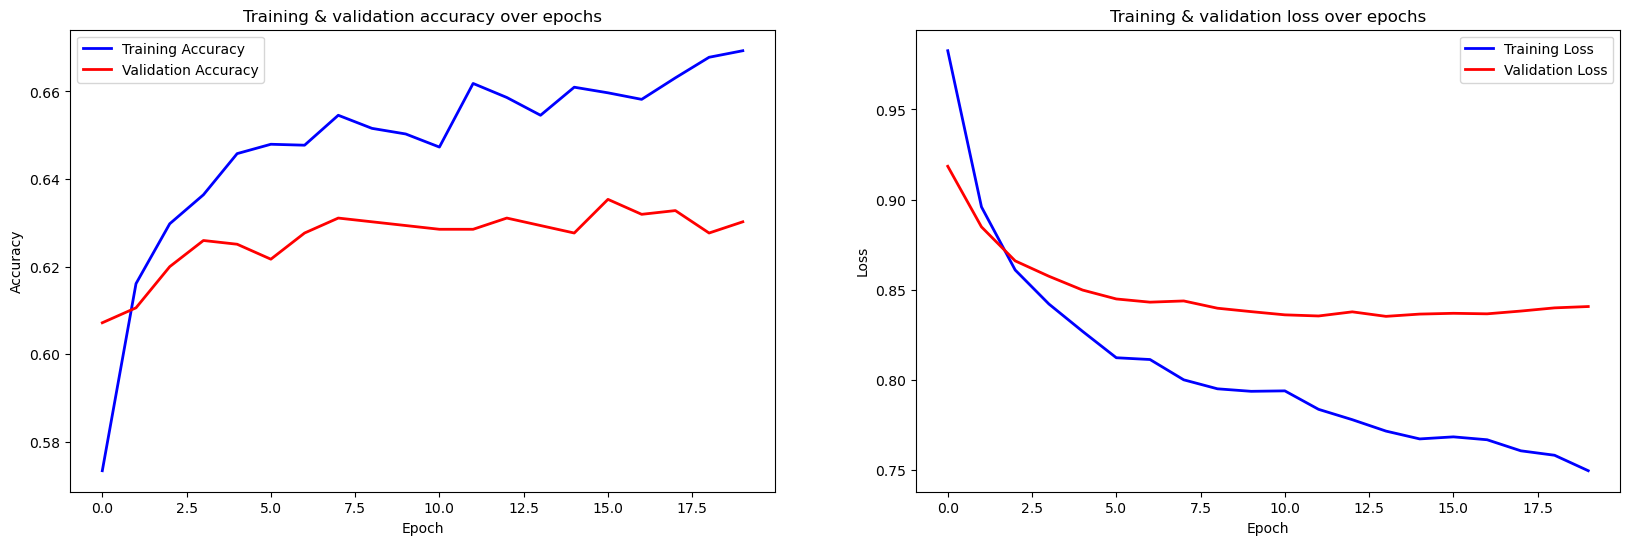

In [27]:
evaluate_model(history_LSTM)

(4681, 1, 1024)
Epoch 1/100
37/37 - 1s - loss: 1.6263 - accuracy: 0.4396 - val_loss: 1.0309 - val_accuracy: 0.6106 - 603ms/epoch - 16ms/step
Epoch 2/100
37/37 - 0s - loss: 1.4257 - accuracy: 0.5095 - val_loss: 0.9636 - val_accuracy: 0.6174 - 162ms/epoch - 4ms/step
Epoch 3/100
37/37 - 0s - loss: 1.3549 - accuracy: 0.5287 - val_loss: 0.9625 - val_accuracy: 0.6140 - 193ms/epoch - 5ms/step
Epoch 4/100
37/37 - 0s - loss: 1.3688 - accuracy: 0.5266 - val_loss: 0.9504 - val_accuracy: 0.6200 - 177ms/epoch - 5ms/step
Epoch 5/100
37/37 - 0s - loss: 1.2942 - accuracy: 0.5458 - val_loss: 0.9356 - val_accuracy: 0.6208 - 183ms/epoch - 5ms/step
Epoch 6/100
37/37 - 0s - loss: 1.2710 - accuracy: 0.5460 - val_loss: 0.9428 - val_accuracy: 0.6140 - 167ms/epoch - 5ms/step
Epoch 7/100
37/37 - 0s - loss: 1.2587 - accuracy: 0.5537 - val_loss: 0.9302 - val_accuracy: 0.6123 - 174ms/epoch - 5ms/step
Epoch 8/100
37/37 - 0s - loss: 1.2375 - accuracy: 0.5584 - val_loss: 0.9247 - val_accuracy: 0.6132 - 174ms/epoch - 

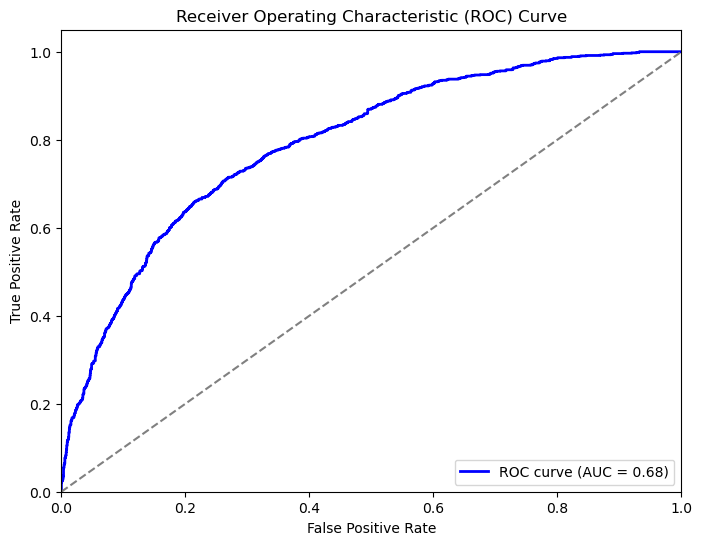

In [28]:
m = model_RNN(1024, input_length=MAX_SEQ_LEN)
history_RNN = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

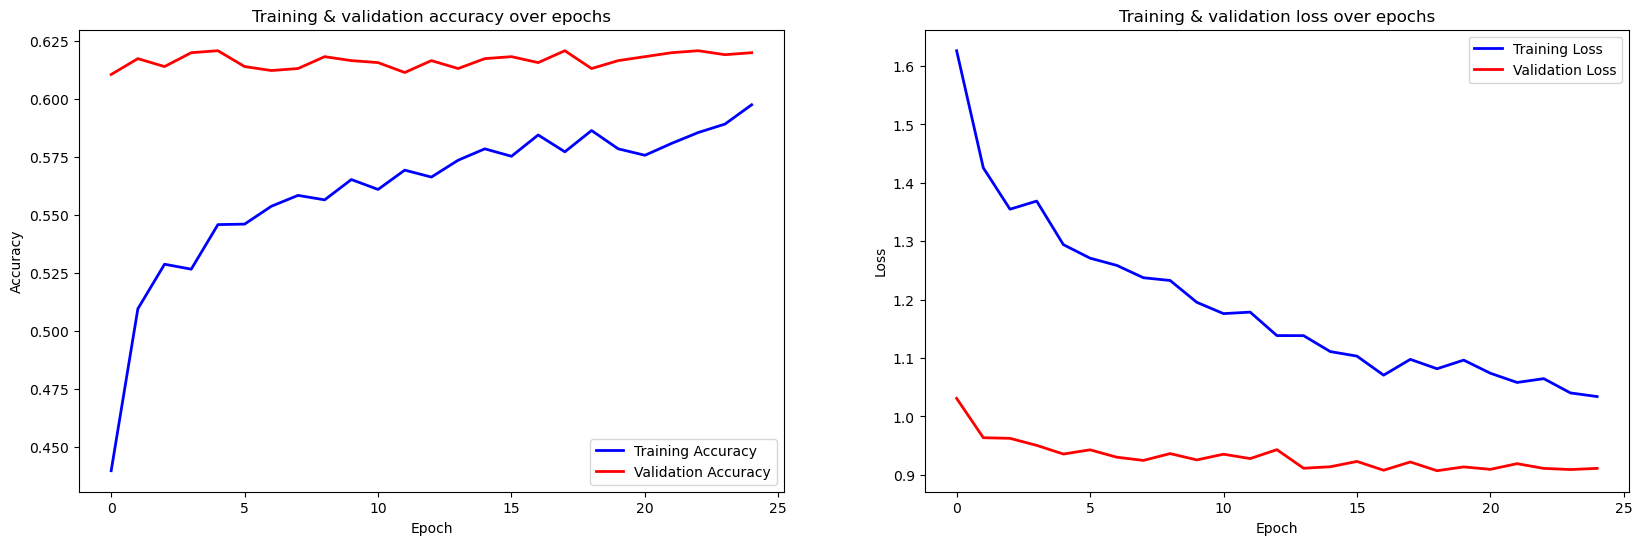

In [29]:
evaluate_model(history_RNN)

(4681, 1, 1024)
Epoch 1/100
37/37 - 1s - loss: 1.0876 - accuracy: 0.4911 - val_loss: 0.9195 - val_accuracy: 0.6046 - 1s/epoch - 34ms/step
Epoch 2/100
37/37 - 0s - loss: 0.9745 - accuracy: 0.5719 - val_loss: 0.8868 - val_accuracy: 0.6132 - 366ms/epoch - 10ms/step
Epoch 3/100
37/37 - 0s - loss: 0.9367 - accuracy: 0.5862 - val_loss: 0.8750 - val_accuracy: 0.6149 - 402ms/epoch - 11ms/step
Epoch 4/100
37/37 - 0s - loss: 0.9227 - accuracy: 0.5920 - val_loss: 0.8665 - val_accuracy: 0.6217 - 393ms/epoch - 11ms/step
Epoch 5/100
37/37 - 0s - loss: 0.8949 - accuracy: 0.6029 - val_loss: 0.8614 - val_accuracy: 0.6183 - 413ms/epoch - 11ms/step
Epoch 6/100
37/37 - 0s - loss: 0.8811 - accuracy: 0.6054 - val_loss: 0.8585 - val_accuracy: 0.6200 - 416ms/epoch - 11ms/step
Epoch 7/100
37/37 - 0s - loss: 0.8774 - accuracy: 0.6078 - val_loss: 0.8564 - val_accuracy: 0.6200 - 435ms/epoch - 12ms/step
Epoch 8/100
37/37 - 0s - loss: 0.8708 - accuracy: 0.6129 - val_loss: 0.8546 - val_accuracy: 0.6217 - 391ms/epoch

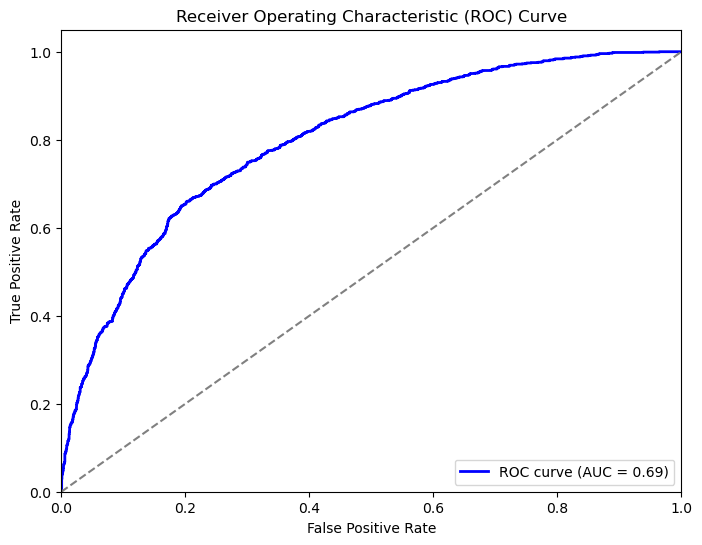

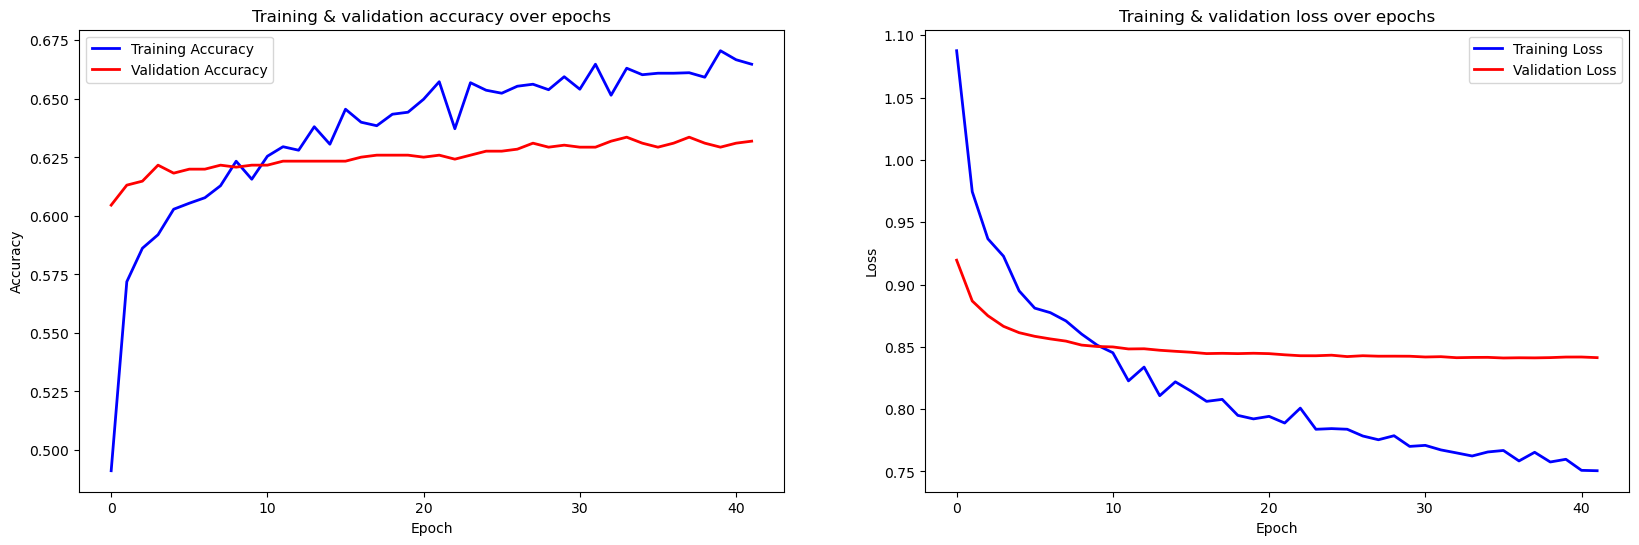

In [30]:
m = model_GRU(1024, input_length=MAX_SEQ_LEN)
history_GRU = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 
evaluate_model(history_GRU)

(4681, 1, 1024)
Epoch 1/100
37/37 - 3s - loss: 0.1095 - accuracy: 0.3835 - val_loss: 0.1083 - val_accuracy: 0.5679 - 3s/epoch - 68ms/step
Epoch 2/100
37/37 - 0s - loss: 0.1071 - accuracy: 0.4775 - val_loss: 0.1055 - val_accuracy: 0.6020 - 147ms/epoch - 4ms/step
Epoch 3/100
37/37 - 0s - loss: 0.1039 - accuracy: 0.5313 - val_loss: 0.1008 - val_accuracy: 0.6072 - 146ms/epoch - 4ms/step
Epoch 4/100
37/37 - 0s - loss: 0.1003 - accuracy: 0.5717 - val_loss: 0.0958 - val_accuracy: 0.6072 - 165ms/epoch - 4ms/step
Epoch 5/100
37/37 - 0s - loss: 0.0978 - accuracy: 0.5815 - val_loss: 0.0931 - val_accuracy: 0.6072 - 171ms/epoch - 5ms/step
Epoch 6/100
37/37 - 0s - loss: 0.0947 - accuracy: 0.5945 - val_loss: 0.0911 - val_accuracy: 0.6072 - 218ms/epoch - 6ms/step
Epoch 7/100
37/37 - 0s - loss: 0.0931 - accuracy: 0.6009 - val_loss: 0.0898 - val_accuracy: 0.6072 - 197ms/epoch - 5ms/step
Epoch 8/100
37/37 - 0s - loss: 0.0916 - accuracy: 0.6054 - val_loss: 0.0891 - val_accuracy: 0.6072 - 186ms/epoch - 5ms

/Users/alkakumari/Documents/hate_speech_detection/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


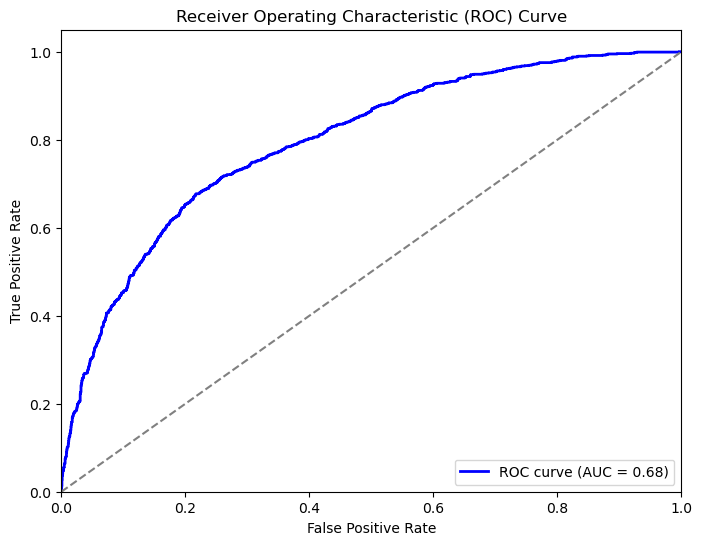

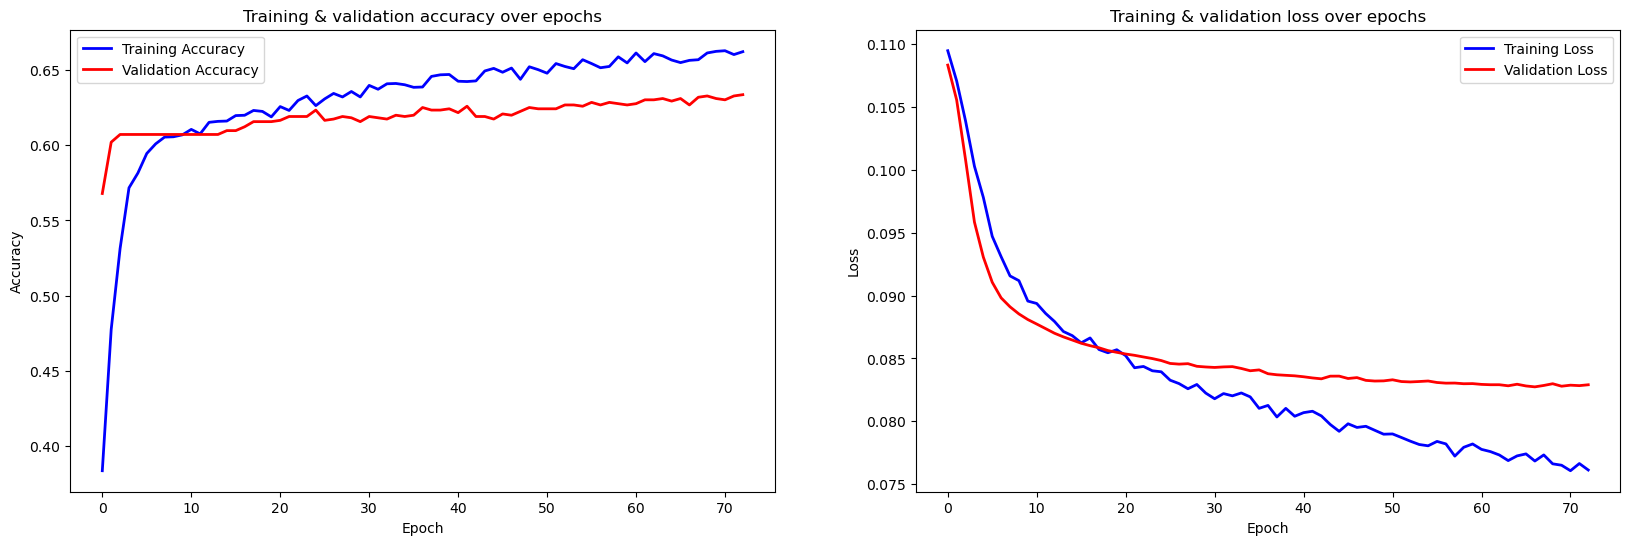

In [31]:
m = novel_model(1024, input_length=MAX_SEQ_LEN, learning_rate=learning_rate)
history_novel = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 
evaluate_model(history_novel)